In [1]:
from keras.models import load_model
model = load_model("CNN_vgg16.keras")

2024-04-18 04:41:48.694968: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-18 04:41:48.694995: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-18 04:41:48.695003: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-18 04:41:48.695024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 04:41:48.695046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/tang/anaconda3/envs/STAT4012/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 62 variab

In [2]:
# obtain the dataset again
import os
import numpy as np
import pandas as pd

from const import *
from data_io import get_poster, plot_poster
from sklearn.model_selection import train_test_split

from tensorflow.keras import Input, Model, datasets
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# read encode dataframe and select only 3 genres
encoded_genre_df = pd.read_csv('encoded_genres.csv', index_col=0)
encoded_genre_df = encoded_genre_df[['_Action', '_Romance', '_Thriller']]
genre_count = np.sum(encoded_genre_df * 1, axis=1)
encoded_filtered = encoded_genre_df.loc[genre_count == 1]

# consider only movies released in year 2000-2024
valid_movies = encoded_genre_df.index
movie_year = pd.read_csv('movies.csv', index_col=0)
movie_year = movie_year['date']
mov = []
for i in valid_movies:
    mov.append(movie_year.iloc[i-1000001])
movie_year = pd.DataFrame(mov)
movie_year.index = valid_movies
movie_year = movie_year.loc[genre_count == 1]

encoded_filtered = encoded_filtered.loc[(movie_year.iloc[:,0] >= 2000) & (movie_year.iloc[:,0] <= 2024)]

In [3]:
movie = []
encode = []
n_genre = encoded_filtered.shape[1]
IMG_SIZE = (345, 230, 3)
size = 4000

np.random.seed(4012)
tf.random.set_seed(4012)

# select 4000 samples from each genre for training and testing
movie_index = []
for i in range(n_genre):
    genre_filtered = encoded_filtered.loc[encoded_filtered.iloc[:,i] == True]
    rand = np.random.randint(0, genre_filtered.shape[0], size=(size+10))
    n_image = 0
    j=0
    while(n_image < size):
        mov = get_poster(genre_filtered.index[rand[j]])
        if(sum(mov.shape) == sum(IMG_SIZE)):
            movie.append(mov)
            encode.append(genre_filtered.iloc[rand[j], :n_genre])
            n_image +=1
        j=j+1

movie = np.array(movie)
encode = np.array(encode, dtype=float).reshape((size*n_genre,n_genre))

In [4]:
# split 4000 movies into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(movie, encode, test_size=0.2, random_state=4012)

In [22]:
# (1) test colour 
X_test_monocolour = []
for i in range(X_test.shape[0]):
    X_i = X_test[i,:,:,:]
    X_im = np.mean(X_i, axis=2)
    X_i = np.zeros(X_test.shape[1:])
    for j in range(3):
        X_i[:,:,j] = X_im
    X_test_monocolour.append(X_i)

X_test_monocolour = np.array(X_test_monocolour)
print(X_test_monocolour.shape)

(2400, 345, 230, 3)


In [23]:
# put model onto testing dataset
predy_mono = model.predict(X_test_monocolour)
predy_class_mono = np.argmax(predy_mono, axis=1)
truey_class = np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(truey_class, predy_class_mono))
# original confusion matrix: 
# [[482 134 184]
#  [119 510 150]
#  [169 170 482]]

75/75 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step
[[409 165 226]
 [ 80 507 192]
 [133 177 511]]


In [24]:
from tensorflow.keras.metrics import AUC
tf_auc_mono = AUC(num_thresholds = 200, from_logits = True, multi_label = True)
tf_auc_mono.update_state(y_test, predy_mono)
print(tf_auc_mono.result().numpy())
# original auc: 0.7903587

0.77747214


In [25]:
# mean f1 score for all genres together
from sklearn.metrics import f1_score
f1_mono = f1_score(truey_class, predy_class_mono, average='macro')
print(f1_mono)
# original f1 score: 0.6144

0.5940320850194268


In [5]:
# (2) test edges
pad = 30
top = pad
bottom = X_test.shape[1]-pad
left = pad
right = X_test.shape[2]-pad

X_test_centre = []
for k in range(X_test.shape[0]):
    X_i = np.zeros(X_test.shape[1:])
    X_i[top:bottom, left:right, :] = X_test[k, top:bottom, left:right, :]
    X_test_centre.append(X_i)
X_test_centre = np.array(X_test_centre)

In [6]:
# feed into the model
predy_centre = model.predict(X_test_centre)
predy_class_centre = np.argmax(predy_centre, axis=1)

2024-04-18 04:42:36.187890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


75/75 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step


In [9]:
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.metrics import AUC
truey_class = np.argmax(y_test, axis=1)
print(confusion_matrix(truey_class, predy_class_centre))
# original confusion matrix: 
# [[482 134 184]
#  [119 510 150]
#  [169 170 482]]
tf_auc_centre = AUC(num_thresholds = 200, from_logits = True, multi_label = True)
tf_auc_centre.update_state(y_test, predy_centre)
print(tf_auc_centre.result().numpy())
# original auc: 0.7903587

f1_centre = f1_score(truey_class, predy_class_centre, average='macro')
print(f1_centre)
# original f1 score: 0.6144

[[202  60 538]
 [ 63 244 472]
 [ 45  40 736]]
0.7337925
0.45731543248149836


In [10]:
# (3) test rotation
X_test_rotate = np.rot90(np.rot90(X_test, axes=(1,2)), axes=(1,2))
predy_rotate = model.predict(X_test_rotate)
predy_class_rotate = np.argmax(predy_rotate, axis=1)

75/75 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step


In [11]:
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.metrics import AUC
truey_class = np.argmax(y_test, axis=1)
print(confusion_matrix(truey_class, predy_class_rotate))
# original confusion matrix: 
# [[482 134 184]
#  [119 510 150]
#  [169 170 482]]
tf_auc_rotate = AUC(num_thresholds = 200, from_logits = True, multi_label = True)
tf_auc_rotate.update_state(y_test, predy_rotate)
print(tf_auc_rotate.result().numpy())
# original auc: 0.7903587

f1_rotate = f1_score(truey_class, predy_class_rotate, average='macro')
print(f1_rotate)
# original f1 score: 0.6144

[[526  94 180]
 [247 345 187]
 [252 115 454]]
0.73696494
0.549017309722622


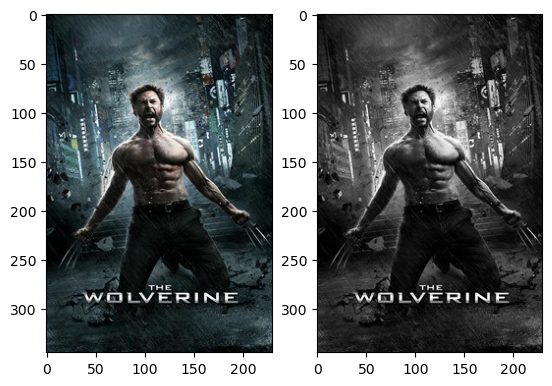

In [26]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2)
pic = 30
ax1.imshow(X_test[pic,:,:,:])
ax2.imshow(X_test_monocolour[pic,:,:,:].astype(int))
plt.savefig('Mono-colour test')

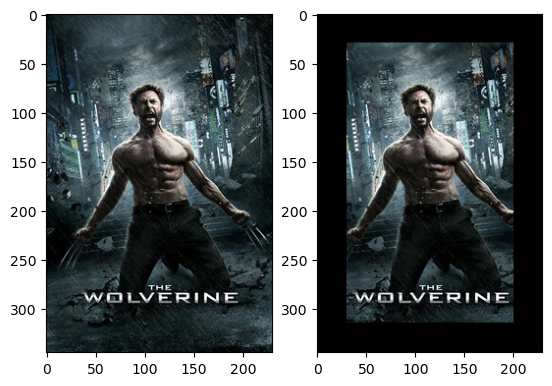

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2)
pic = 30
ax1.imshow(X_test[pic,:,:,:])
ax2.imshow(X_test_centre[pic,:,:,:].astype(int))
plt.savefig('Corner test')

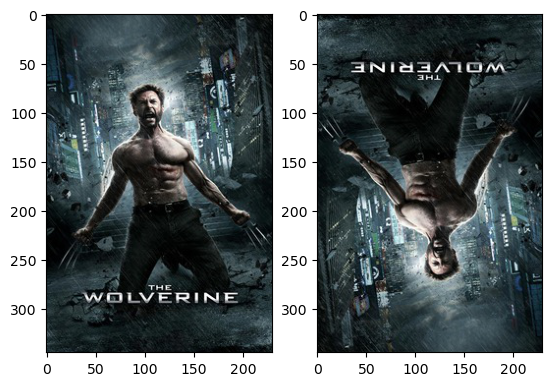

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2)
pic = 30
ax1.imshow(X_test[pic,:,:,:])
ax2.imshow(X_test_rotate[pic,:,:,:])
plt.savefig('Rotation test')